In [1]:
import os
os.environ['CUDA_VISIBLE_DEVICES'] = '0'
import torch
import os
import pandas as pd
import numpy as np
from PIL import Image
from tqdm import tqdm
import torch.nn.functional as F
from extractor_sd import load_model, process_features_and_mask, get_mask
from utils.utils_correspondence import co_pca, resize, find_nearest_patchs, find_nearest_patchs_replace
import matplotlib.pyplot as plt
import sys
from extractor_dino import ViTExtractor
from sklearn.decomposition import PCA as sklearnPCA
import math
from sklearn.cluster import KMeans
from scipy.optimize import linear_sum_assignment

/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
MASK = True
VER = "v1-5"
PCA = False
CO_PCA = True
PCA_DIMS = [256, 256, 256]
SIZE =960
EDGE_PAD = False

FUSE_DINO = 1
ONLY_DINO = 0
DINOV2 = True
MODEL_SIZE = 'base'
DRAW_DENSE = 1
DRAW_SWAP = 1
TEXT_INPUT = False
SEED = 42
TIMESTEP = 100

DIST = 'l2' if FUSE_DINO and not ONLY_DINO else 'cos'
if ONLY_DINO:
    FUSE_DINO = True

In [3]:
np.random.seed(SEED)
torch.manual_seed(SEED)
torch.cuda.manual_seed(SEED)
torch.backends.cudnn.benchmark = True

model, aug = load_model(diffusion_ver=VER, image_size=SIZE, num_timesteps=TIMESTEP)

LatentDiffusion: Running in eps-prediction mode
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 320, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 640, context_dim is 768 and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, context_dim is None and using 8 heads.
Setting up MemoryEfficientCrossAttention. Query dim is 1280, con

The checkpoint state_dict contains keys that are not used by the model:
  model_ema.{decay, num_updates}
backbone.feature_extractor.,category_head.clip.clip.,clip_head.clip.clip.


In [4]:
def compute_pair_feature(model, aug, save_path, files, category, mask=False, dist='cos', real_size=960):
    if type(category) == str:
        category = [category]
    img_size = 840 if DINOV2 else 244
    model_dict={'small':'dinov2_vits14',
                'base':'dinov2_vitb14',
                'large':'dinov2_vitl14',
                'giant':'dinov2_vitg14'}
    
    model_type = model_dict[MODEL_SIZE] if DINOV2 else 'dino_vits8'
    layer = 11 if DINOV2 else 9
    if 'l' in model_type:
        layer = 23
    elif 'g' in model_type:
        layer = 39
    facet = 'token' if DINOV2 else 'key'
    stride = 14 if DINOV2 else 4
    device = 'cuda' if torch.cuda.is_available() else 'cpu'
    # indiactor = 'v2' if DINOV2 else 'v1'
    # model_size = model_type.split('vit')[-1]
    extractor = ViTExtractor(model_type, stride, device=device)
    patch_size = extractor.model.patch_embed.patch_size[0] if DINOV2 else extractor.model.patch_embed.patch_size
    num_patches = int(patch_size / stride * (img_size // patch_size - 1) + 1)
    
    input_text = "a photo of "+category[-1][0] if TEXT_INPUT else None

    current_save_results = 0

    N = len(files) // 2
    pbar = tqdm(total=N)
    result = []
    if 'Anno' in files[0]:
        Anno=True
    else:
        Anno=False
    for pair_idx in range(N):

        # Load image 1
        img1 = Image.open(files[2*pair_idx]).convert('RGB')
        img1_input = resize(img1, real_size, resize=True, to_pil=True, edge=EDGE_PAD)
        img1 = resize(img1, img_size, resize=True, to_pil=True, edge=EDGE_PAD)

        # Load image 2
        img2 = Image.open(files[2*pair_idx+1]).convert('RGB')
        img2_input = resize(img2, real_size, resize=True, to_pil=True, edge=EDGE_PAD)
        img2 = resize(img2, img_size, resize=True, to_pil=True, edge=EDGE_PAD)

        with torch.no_grad():
            if not CO_PCA:
                if not ONLY_DINO:
                    img1_desc = process_features_and_mask(model, aug, img1_input, input_text=input_text, mask=False, pca=PCA).reshape(1,1,-1, num_patches**2).permute(0,1,3,2)
                    img2_desc = process_features_and_mask(model, aug, img2_input, category[-1], input_text=input_text,  mask=mask, pca=PCA).reshape(1,1,-1, num_patches**2).permute(0,1,3,2)
                if FUSE_DINO:
                    img1_batch = extractor.preprocess_pil(img1)
                    img1_desc_dino = extractor.extract_descriptors(img1_batch.to(device), layer, facet)
                    img2_batch = extractor.preprocess_pil(img2)
                    img2_desc_dino = extractor.extract_descriptors(img2_batch.to(device), layer, facet)

            else:
                if not ONLY_DINO:
                    features1 = process_features_and_mask(model, aug, img1_input, input_text=input_text,  mask=False, raw=True)
                    features2 = process_features_and_mask(model, aug, img2_input, input_text=input_text,  mask=False, raw=True)
                    processed_features1, processed_features2 = co_pca(features1, features2, PCA_DIMS)
                    img1_desc = processed_features1.reshape(1, 1, -1, num_patches**2).permute(0,1,3,2)
                    img2_desc = processed_features2.reshape(1, 1, -1, num_patches**2).permute(0,1,3,2)
                if FUSE_DINO:
                    img1_batch = extractor.preprocess_pil(img1)
                    img1_desc_dino = extractor.extract_descriptors(img1_batch.to(device), layer, facet)
                    img2_batch = extractor.preprocess_pil(img2)
                    img2_desc_dino = extractor.extract_descriptors(img2_batch.to(device), layer, facet)
                
            if dist == 'l1' or dist == 'l2':
                # normalize the features
                img1_desc = img1_desc / img1_desc.norm(dim=-1, keepdim=True)
                img2_desc = img2_desc / img2_desc.norm(dim=-1, keepdim=True)
                if FUSE_DINO:
                    img1_desc_dino = img1_desc_dino / img1_desc_dino.norm(dim=-1, keepdim=True)
                    img2_desc_dino = img2_desc_dino / img2_desc_dino.norm(dim=-1, keepdim=True)

            if FUSE_DINO and not ONLY_DINO:
                # cat two features together
                img1_desc = torch.cat((img1_desc, img1_desc_dino), dim=-1)
                img2_desc = torch.cat((img2_desc, img2_desc_dino), dim=-1)

            if ONLY_DINO:
                img1_desc = img1_desc_dino
                img2_desc = img2_desc_dino

            if DRAW_DENSE:
                if not Anno:
                    mask1 = get_mask(model, aug, img1, category[0])
                    mask2 = get_mask(model, aug, img2, category[-1])
                if Anno:
                    mask1 = torch.Tensor(resize(img1, img_size, resize=True, to_pil=False, edge=EDGE_PAD).mean(-1)>0).to(device)
                    mask2 = torch.Tensor(resize(img2, img_size, resize=True, to_pil=False, edge=EDGE_PAD).mean(-1)>0).to(device)
                    print(mask1.shape, mask2.shape,mask1.sum(), mask2.sum())
                if ONLY_DINO or not FUSE_DINO:
                    img1_desc = img1_desc / img1_desc.norm(dim=-1, keepdim=True)
                    img2_desc = img2_desc / img2_desc.norm(dim=-1, keepdim=True)
                
                img1_desc_reshaped = img1_desc.permute(0,1,3,2).reshape(-1, img1_desc.shape[-1], num_patches, num_patches)
                img2_desc_reshaped = img2_desc.permute(0,1,3,2).reshape(-1, img2_desc.shape[-1], num_patches, num_patches)
                trg_dense_output, src_color_map = find_nearest_patchs(mask2, mask1, img2, img1, img2_desc_reshaped, img1_desc_reshaped, mask=mask)

                if not os.path.exists(f'{save_path}/{category[0]}'):
                    os.makedirs(f'{save_path}/{category[0]}')
                fig_colormap, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                ax1.axis('off')
                ax2.axis('off')
                ax1.imshow(src_color_map)
                ax2.imshow(trg_dense_output)
                fig_colormap.savefig(f'{save_path}/{category[0]}/{pair_idx}_colormap.png')
                plt.close(fig_colormap)
            
            if DRAW_SWAP:
                if not DRAW_DENSE:
                    mask1 = get_mask(model, aug, img1, category[0])
                    mask2 = get_mask(model, aug, img2, category[-1])

                if (ONLY_DINO or not FUSE_DINO) and not DRAW_DENSE:
                    img1_desc = img1_desc / img1_desc.norm(dim=-1, keepdim=True)
                    img2_desc = img2_desc / img2_desc.norm(dim=-1, keepdim=True)
                    
                img1_desc_reshaped = img1_desc.permute(0,1,3,2).reshape(-1, img1_desc.shape[-1], num_patches, num_patches)
                img2_desc_reshaped = img2_desc.permute(0,1,3,2).reshape(-1, img2_desc.shape[-1], num_patches, num_patches)
                trg_dense_output, src_color_map = find_nearest_patchs_replace(mask2, mask1, img2, img1, img2_desc_reshaped, img1_desc_reshaped, mask=mask, resolution=156)
                if not os.path.exists(f'{save_path}/{category[0]}'):
                    os.makedirs(f'{save_path}/{category[0]}')
                fig_colormap, (ax1, ax2) = plt.subplots(1, 2, figsize=(16, 8))
                ax1.axis('off')
                ax2.axis('off')
                ax1.imshow(src_color_map)
                ax2.imshow(trg_dense_output)
                fig_colormap.savefig(f'{save_path}/{category[0]}/{pair_idx}_swap.png')
                plt.close(fig_colormap)
            if not DRAW_SWAP and not DRAW_DENSE:
                result.append([img1_desc.cpu(), img2_desc.cpu()])
            else:
                result.append([img1_desc.cpu(), img2_desc.cpu(), mask1.cpu(), mask2.cpu()])

    pbar.update(1)
    return result

In [5]:
def vis_pca_mask(result,save_path):
    # PCA visualization mask version
    for (feature1,feature2,mask1,mask2) in result:
        # feature1 shape (1,1,3600,768*2)
        # feature2 shape (1,1,3600,768*2)
        num_patches = int(math.sqrt(feature1.shape[-2]))
        # pca the concatenated feature to 3 dimensions
        feature1 = feature1.squeeze() # shape (3600,768*2)
        feature2 = feature2.squeeze() # shape (3600,768*2)
        chennel_dim = feature1.shape[-1]
        # resize back
        src_feature_reshaped = feature1.squeeze().permute(1,0).reshape(-1,num_patches,num_patches).cuda()
        tgt_feature_reshaped = feature2.squeeze().permute(1,0).reshape(-1,num_patches,num_patches).cuda()
        resized_src_mask = F.interpolate(mask1.unsqueeze(0).unsqueeze(0), size=(num_patches, num_patches), mode='nearest').squeeze().cuda()
        resized_tgt_mask = F.interpolate(mask2.unsqueeze(0).unsqueeze(0), size=(num_patches, num_patches), mode='nearest').squeeze().cuda()
        src_feature_upsampled = src_feature_reshaped * resized_src_mask.repeat(src_feature_reshaped.shape[0],1,1)
        tgt_feature_upsampled = tgt_feature_reshaped * resized_tgt_mask.repeat(src_feature_reshaped.shape[0],1,1)
        feature1=src_feature_upsampled.reshape(chennel_dim,-1).permute(1,0)
        feature2=tgt_feature_upsampled.reshape(chennel_dim,-1).permute(1,0)

        n_components=4 # the first component is to seperate the object from the background
        pca = sklearnPCA(n_components=n_components)
        feature1_n_feature2 = torch.cat((feature1,feature2),dim=0) # shape (7200,768*2)
        feature1_n_feature2 = pca.fit_transform(feature1_n_feature2.cpu().numpy()) # shape (7200,3)
        feature1 = feature1_n_feature2[:feature1.shape[0],:] # shape (3600,3)
        feature2 = feature1_n_feature2[feature1.shape[0]:,:] # shape (3600,3)
        
        
        fig, axes = plt.subplots(4, 2, figsize=(10, 14))
        for show_channel in range(n_components):
            if show_channel==0:
                continue
            # min max normalize the feature map
            feature1[:, show_channel] = (feature1[:, show_channel] - feature1[:, show_channel].min()) / (feature1[:, show_channel].max() - feature1[:, show_channel].min())
            feature2[:, show_channel] = (feature2[:, show_channel] - feature2[:, show_channel].min()) / (feature2[:, show_channel].max() - feature2[:, show_channel].min())
            feature1_first_channel = feature1[:, show_channel].reshape(num_patches,num_patches)
            feature2_first_channel = feature2[:, show_channel].reshape(num_patches,num_patches)

            axes[show_channel-1, 0].imshow(feature1_first_channel)
            axes[show_channel-1, 0].axis('off')
            axes[show_channel-1, 1].imshow(feature2_first_channel)
            axes[show_channel-1, 1].axis('off')
            axes[show_channel-1, 0].set_title('Feature 1 - Channel {}'.format(show_channel ), fontsize=14)
            axes[show_channel-1, 1].set_title('Feature 2 - Channel {}'.format(show_channel ), fontsize=14)


        feature1_resized = feature1[:, 1:4].reshape(num_patches,num_patches, 3)
        feature2_resized = feature2[:, 1:4].reshape(num_patches,num_patches, 3)

        axes[3, 0].imshow(feature1_resized)
        axes[3, 0].axis('off')
        axes[3, 1].imshow(feature2_resized)
        axes[3, 1].axis('off')
        axes[3, 0].set_title('Feature 1 - All Channels', fontsize=14)
        axes[3, 1].set_title('Feature 2 - All Channels', fontsize=14)

        plt.tight_layout()
        plt.show()
        fig.savefig(save_path+'/masked_pca.png', dpi=300)

def vis_pca(result,save_path,src_img_path,trg_img_path):
    # PCA visualization
    for (feature1,feature2,mask1,mask2) in result:
        # feature1 shape (1,1,3600,768*2)
        # feature2 shape (1,1,3600,768*2)
        num_patches=int(math.sqrt(feature1.shape[2]))
        # pca the concatenated feature to 3 dimensions
        feature1 = feature1.squeeze() # shape (3600,768*2)
        feature2 = feature2.squeeze() # shape (3600,768*2)
        chennel_dim = feature1.shape[-1]
        # resize back
        h1, w1 = Image.open(src_img_path).size
        scale_h1 = h1/num_patches
        scale_w1 = w1/num_patches
        
        if scale_h1 > scale_w1:
            scale = scale_h1
            scaled_w = int(w1/scale)
            feature1 = feature1.reshape(num_patches,num_patches,chennel_dim)
            feature1_uncropped=feature1[(num_patches-scaled_w)//2:num_patches-(num_patches-scaled_w)//2,:,:]
        else:
            scale = scale_w1
            scaled_h = int(h1/scale)
            feature1 = feature1.reshape(num_patches,num_patches,chennel_dim)
            feature1_uncropped=feature1[:,(num_patches-scaled_h)//2:num_patches-(num_patches-scaled_h)//2,:]
        
        h2, w2 = Image.open(trg_img_path).size
        scale_h2 = h2/num_patches
        scale_w2 = w2/num_patches
        if scale_h2 > scale_w2:
            scale = scale_h2
            scaled_w = int(w2/scale)
            feature2 = feature2.reshape(num_patches,num_patches,chennel_dim)
            feature2_uncropped=feature2[(num_patches-scaled_w)//2:num_patches-(num_patches-scaled_w)//2,:,:]
        else:
            scale = scale_w2
            scaled_h = int(h2/scale)
            feature2 = feature2.reshape(num_patches,num_patches,chennel_dim)
            feature2_uncropped=feature2[:,(num_patches-scaled_h)//2:num_patches-(num_patches-scaled_h)//2,:]

        f1_shape=feature1_uncropped.shape[:2]
        f2_shape=feature2_uncropped.shape[:2]
        feature1 = feature1_uncropped.reshape(f1_shape[0]*f1_shape[1],chennel_dim)
        feature2 = feature2_uncropped.reshape(f2_shape[0]*f2_shape[1],chennel_dim)
        n_components=3
        pca = sklearnPCA(n_components=n_components)
        feature1_n_feature2 = torch.cat((feature1,feature2),dim=0) # shape (7200,768*2)
        feature1_n_feature2 = pca.fit_transform(feature1_n_feature2.cpu().numpy()) # shape (7200,3)
        feature1 = feature1_n_feature2[:feature1.shape[0],:] # shape (3600,3)
        feature2 = feature1_n_feature2[feature1.shape[0]:,:] # shape (3600,3)
        
        
        fig, axes = plt.subplots(4, 2, figsize=(10, 14))
        for show_channel in range(n_components):
            # min max normalize the feature map
            feature1[:, show_channel] = (feature1[:, show_channel] - feature1[:, show_channel].min()) / (feature1[:, show_channel].max() - feature1[:, show_channel].min())
            feature2[:, show_channel] = (feature2[:, show_channel] - feature2[:, show_channel].min()) / (feature2[:, show_channel].max() - feature2[:, show_channel].min())
            feature1_first_channel = feature1[:, show_channel].reshape(f1_shape[0], f1_shape[1])
            feature2_first_channel = feature2[:, show_channel].reshape(f2_shape[0], f2_shape[1])

            axes[show_channel, 0].imshow(feature1_first_channel)
            axes[show_channel, 0].axis('off')
            axes[show_channel, 1].imshow(feature2_first_channel)
            axes[show_channel, 1].axis('off')
            axes[show_channel, 0].set_title('Feature 1 - Channel {}'.format(show_channel + 1), fontsize=14)
            axes[show_channel, 1].set_title('Feature 2 - Channel {}'.format(show_channel + 1), fontsize=14)


        feature1_resized = feature1[:, :3].reshape(f1_shape[0], f1_shape[1], 3)
        feature2_resized = feature2[:, :3].reshape(f2_shape[0], f2_shape[1], 3)

        axes[3, 0].imshow(feature1_resized)
        axes[3, 0].axis('off')
        axes[3, 1].imshow(feature2_resized)
        axes[3, 1].axis('off')
        axes[3, 0].set_title('Feature 1 - All Channels', fontsize=14)
        axes[3, 1].set_title('Feature 2 - All Channels', fontsize=14)

        plt.tight_layout()
        plt.show()
        fig.savefig(save_path+'/pca.png', dpi=300)


def perform_clustering(features, n_clusters=10):
    # Normalize features
    features = F.normalize(features, p=2, dim=1)
    # Convert the features to float32
    features = features.cpu().detach().numpy().astype('float32')
    # Initialize a k-means clustering index with the desired number of clusters
    kmeans = KMeans(n_clusters=n_clusters, random_state=0)
    # Train the k-means index with the features
    kmeans.fit(features)
    # Assign the features to their nearest cluster
    labels = kmeans.predict(features)

    return labels

def cluster_and_match(result, save_path, n_clusters=6):
    for (feature1,feature2,mask1,mask2) in result:
        # feature1 shape (1,1,3600,768*2)
        num_patches = int(math.sqrt(feature1.shape[-2]))
        # pca the concatenated feature to 3 dimensions
        feature1 = feature1.squeeze() # shape (3600,768*2)
        feature2 = feature2.squeeze() # shape (3600,768*2)
        chennel_dim = feature1.shape[-1]
        # resize back

        src_feature_reshaped = feature1.squeeze().permute(1,0).reshape(-1,num_patches,num_patches).cuda()
        tgt_feature_reshaped = feature2.squeeze().permute(1,0).reshape(-1,num_patches,num_patches).cuda()
        resized_src_mask = F.interpolate(mask1.unsqueeze(0).unsqueeze(0), size=(num_patches, num_patches), mode='nearest').squeeze().cuda()
        resized_tgt_mask = F.interpolate(mask2.unsqueeze(0).unsqueeze(0), size=(num_patches, num_patches), mode='nearest').squeeze().cuda()
        src_feature_upsampled = src_feature_reshaped * resized_src_mask.repeat(src_feature_reshaped.shape[0],1,1)
        tgt_feature_upsampled = tgt_feature_reshaped * resized_tgt_mask.repeat(src_feature_reshaped.shape[0],1,1)

        feature1=src_feature_upsampled.unsqueeze(0)
        feature2=tgt_feature_upsampled.unsqueeze(0)
        
        w1, h1 = feature1.shape[2], feature1.shape[3]
        w2, h2 = feature2.shape[2], feature2.shape[3]

        features1_2d = feature1.reshape(feature1.shape[1], -1).permute(1, 0)
        features2_2d = feature2.reshape(feature2.shape[1], -1).permute(1, 0)

        labels_img1 = perform_clustering(features1_2d, n_clusters)
        labels_img2 = perform_clustering(features2_2d, n_clusters)

        cluster_means_img1 = [features1_2d.cpu().detach().numpy()[labels_img1 == i].mean(axis=0) for i in range(n_clusters)]
        cluster_means_img2 = [features2_2d.cpu().detach().numpy()[labels_img2 == i].mean(axis=0) for i in range(n_clusters)]

        distances = np.linalg.norm(np.expand_dims(cluster_means_img1, axis=1) - np.expand_dims(cluster_means_img2, axis=0), axis=-1)
        # Use Hungarian algorithm to find the optimal bijective mapping
        row_ind, col_ind = linear_sum_assignment(distances)

        relabeled_img2 = np.zeros_like(labels_img2)
        for i, match in zip(row_ind, col_ind):
            relabeled_img2[labels_img2 == match] = i

        labels_img1 = labels_img1.reshape(w1, h1)
        relabeled_img2 = relabeled_img2.reshape(w2, h2)
        fig, axs = plt.subplots(1, 2, figsize=(10, 5))
        # Plot the results
        ax_img1 = axs[0]
        axs[0].axis('off')
        ax_img1.imshow(labels_img1, cmap='tab20')
        
        ax_img2 = axs[1]
        axs[1].axis('off')
        ax_img2.imshow(relabeled_img2, cmap='tab20')

        plt.tight_layout()
        plt.show()
        fig.savefig(save_path+'/clustering.png', dpi=300)

Using cache found in /home/junyi/.cache/torch/hub/facebookresearch_dinov2_main
  0%|          | 0/1 [00:00<?, ?it/s]/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/torch/functional.py:504: UserWarning: torch.meshgrid: in an upcoming release, it will be required to pass the indexing argument. (Triggered internally at /opt/conda/conda-bld/pytorch_1670525551200/work/aten/src/ATen/native/TensorShape.cpp:3190.)
  return _VF.meshgrid(tensors, **kwargs)  # type: ignore[attr-defined]
100%|██████████| 1/1 [00:13<00:00, 13.99s/it]


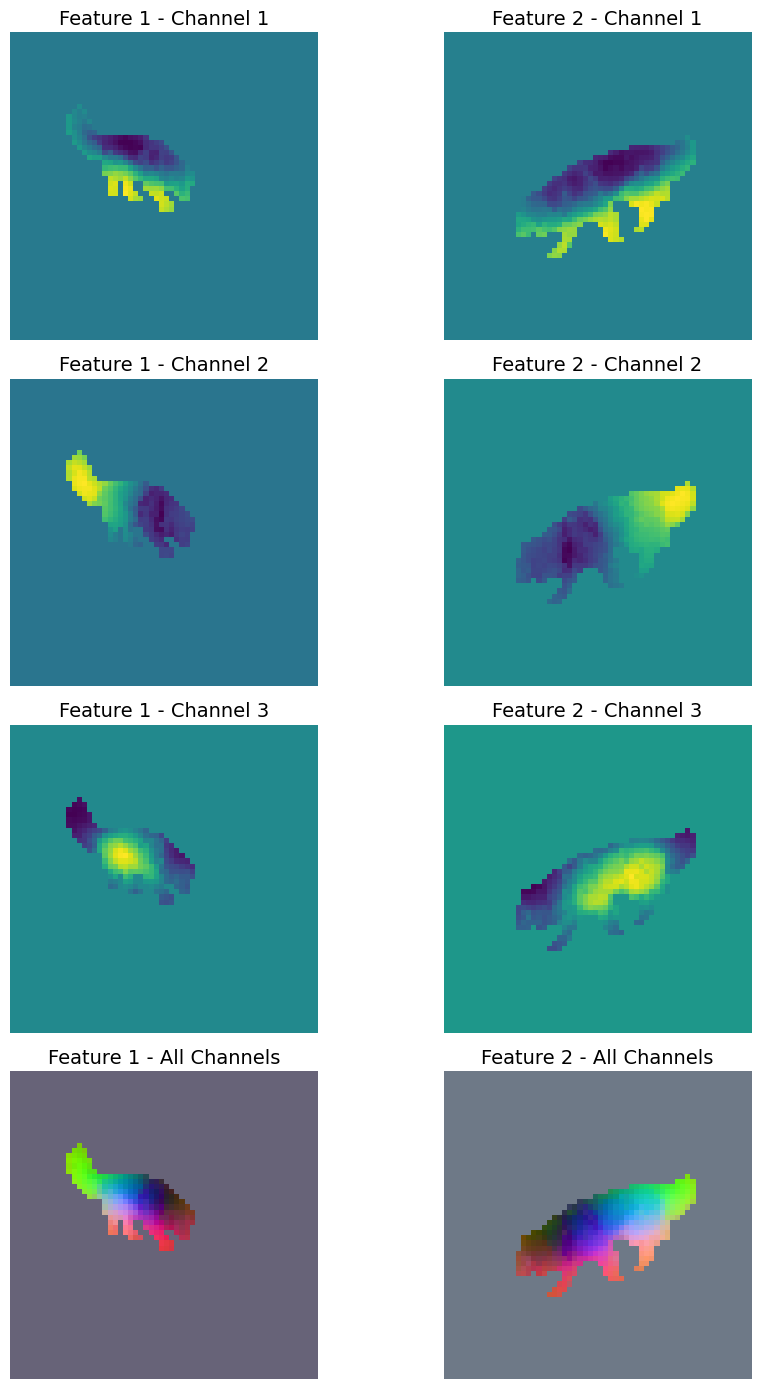

/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


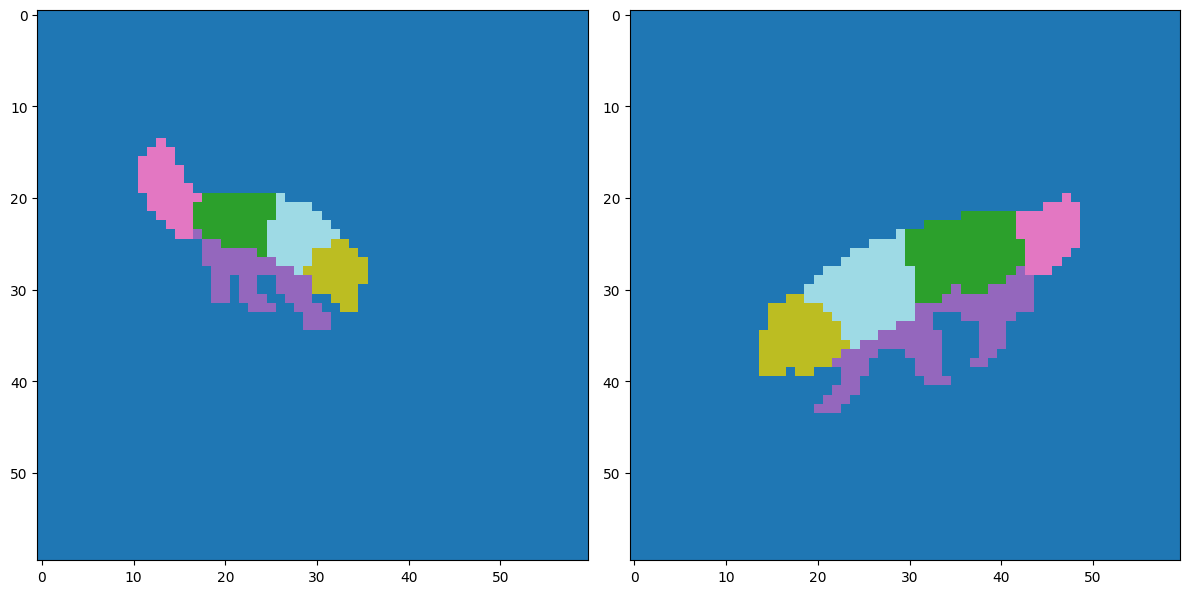

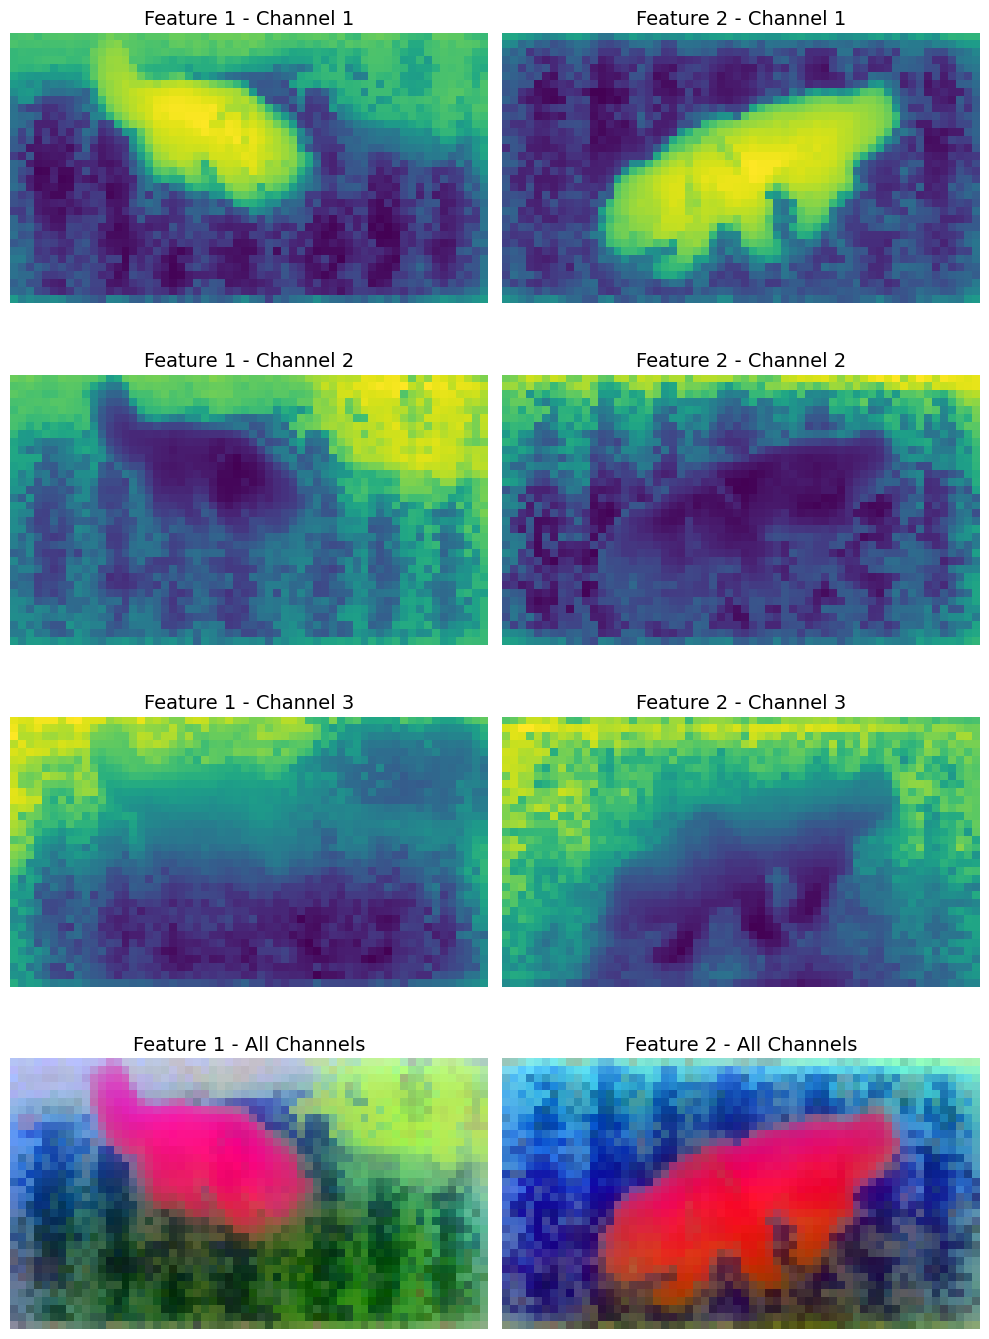

In [8]:
def process_images(src_img_path,trg_img_path):

    categories = [['dog'], ['dog']]
    files = [src_img_path, trg_img_path]
    save_path = './results_vis' + f'/{trg_img_path.split("/")[-1].split(".")[0]}_{src_img_path.split("/")[-1].split(".")[0]}'
    result = compute_pair_feature(model, aug, save_path, files, mask=MASK, category=categories, dist=DIST)
    if MASK:
        vis_pca_mask(result, save_path)
        cluster_and_match(result, save_path)
    if 'Anno' not in src_img_path:
        vis_pca(result, save_path,src_img_path,trg_img_path)

    return result

src_img_path = "data/images/dog_00.jpg"
trg_img_path = "data/images/dog_59.jpg"
result = process_images(src_img_path, trg_img_path)

Using cache found in /home/junyi/.cache/torch/hub/facebookresearch_dinov2_main


torch.Size([840, 840]) torch.Size([840, 840]) tensor(44741., device='cuda:0') tensor(79175., device='cuda:0')


100%|██████████| 1/1 [00:03<00:00,  3.57s/it]


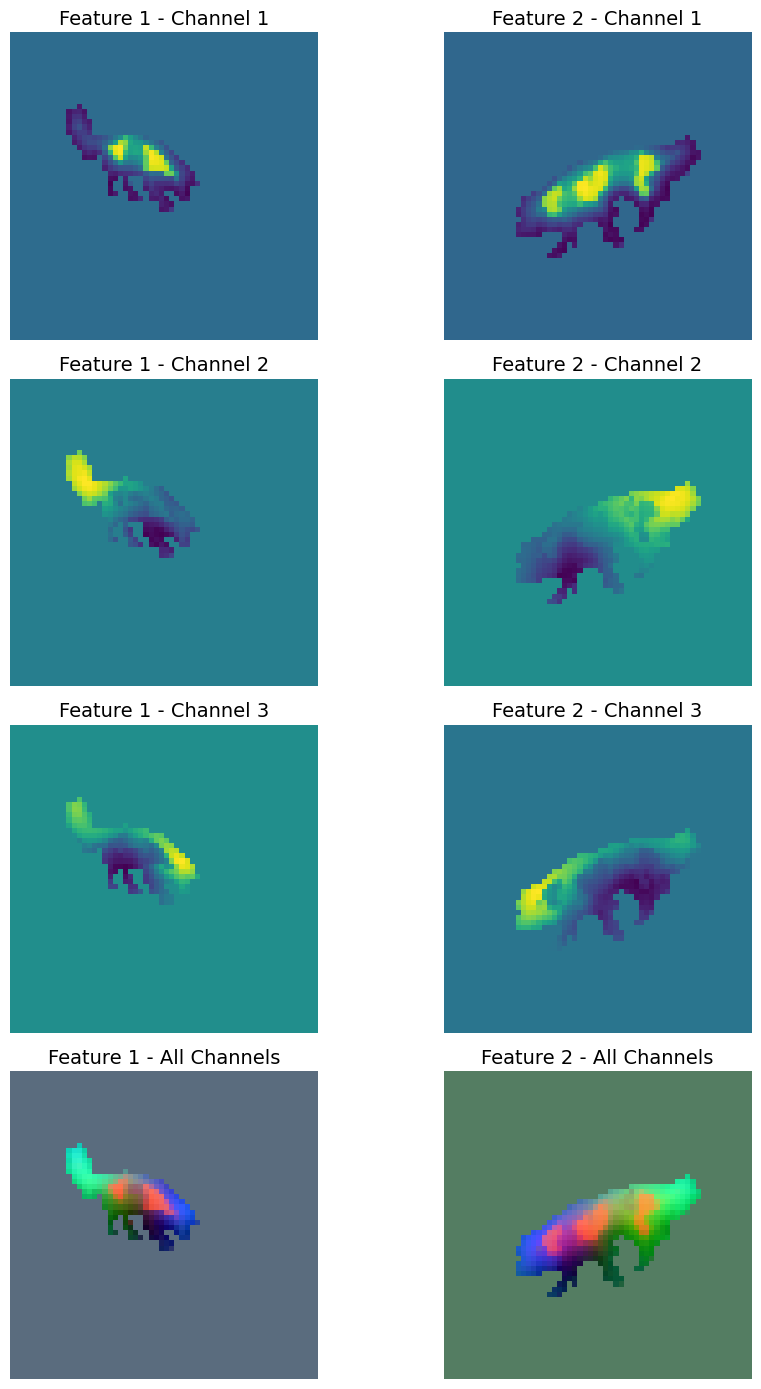

/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(
/home/junyi/miniconda3/envs/sd_dino/lib/python3.9/site-packages/sklearn/cluster/_kmeans.py:870: FutureWarning: The default value of `n_init` will change from 10 to 'auto' in 1.4. Set the value of `n_init` explicitly to suppress the warning
  warnings.warn(


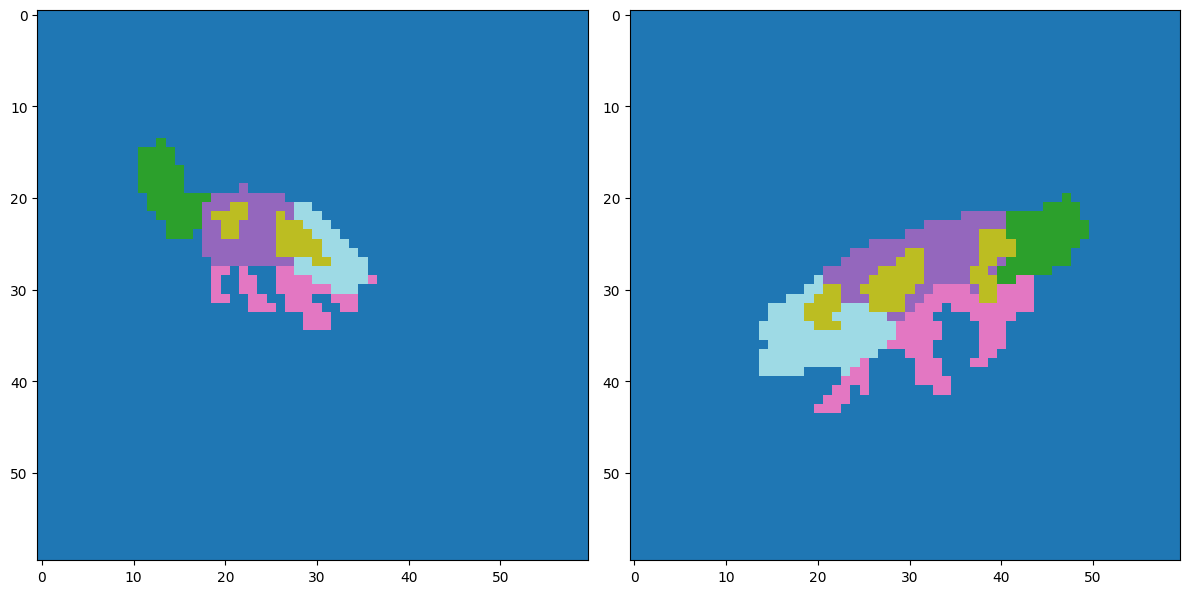

In [10]:
src_img_path = "data/images/dog_Anno_00.png"
trg_img_path = "data/images/dog_Anno_59.png"
result = process_images(src_img_path, trg_img_path)